<a href="https://colab.research.google.com/github/hyeonzz/ESAA_24-1_OB/blob/writing/0315%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0315과제: 캐글 필사-Stacked Regressions : Top 4% on LeaderBoard**    
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook

The features engeneering
- **Inputing missing values** by proceeding sequentially through the data
- **Transforming** some numerical variables that seem really categorical
- **Label Encoding** some categorical variabels that may contain infromation in their ordering set
- **Box Cox Transformation** of skewed features (instead of log-transformation): slightly better result both on leaderboard and cross-validation.
- **Gettimg dummy variables for categorical features.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
  pass
warnings.warn = ignore_warn  #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

In [3]:
# Now let's import and put the train and test datasets in pandas dataframe

train = pd.read_csv("/content/drive/MyDrive/ESAA_OB/DATA/SR_train.csv")
test = pd.read_csv("/content/drive/MyDrive/ESAA_OB/DATA/SR_test.csv")

In [4]:
# display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {}".format(train.shape))
print("The test data size before dropping Id feature is : {}".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the 'Id' colum since it's unnessary for the preidiction process.
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

#check again the data size after dropping the 'Id' variable
print("The train data size after dropping Id feature is : {}".format(train.shape))
print("The test data size after dropping Id feature is : {}".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)
The train data size after dropping Id feature is : (1460, 80)
The test data size after dropping Id feature is : (1459, 79)


##**Data Processing**
###**Outliers**

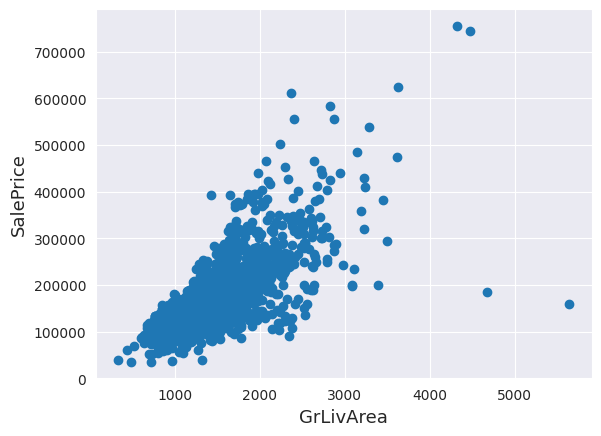

In [7]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

오른쪽 아래 GrLivArea가 매우 크고 SalePrice가 작은 데이터들을 볼 수 있는데 이는 굉장히 많이 벗어난 아웃라이어로 이를 제거할 것.

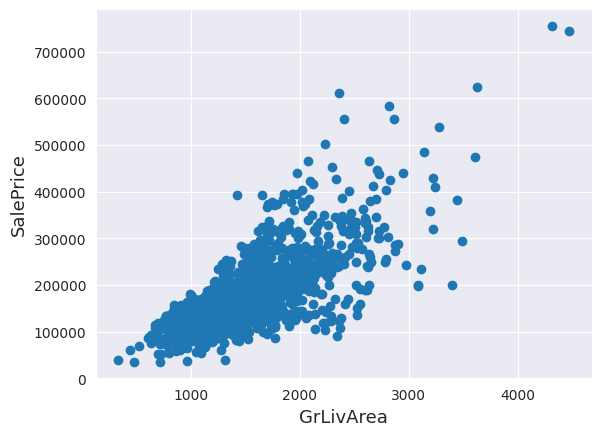

In [8]:
#Deleting outliers -> 2개의 점 삭제
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

**NOTE**
- 아웃라이어 제거는 극단적으로 크고 안 좋은 값으로 삭제해야한다.
- 모든 아웃라이어를 제거하는 것은 테스트 데이터에 아웃라이어가 있을 경우 모델에 안 좋은 영향을 줄 수 있으므로 약간의 아웃라이어를 남겨두어 모델이 아웃라이어도 고려할 수 있도록 한다.

###**Target Variable**
**SalePrice**: 예측해야할 변수.


 mu = 180932.92 and sigma = 79467.79



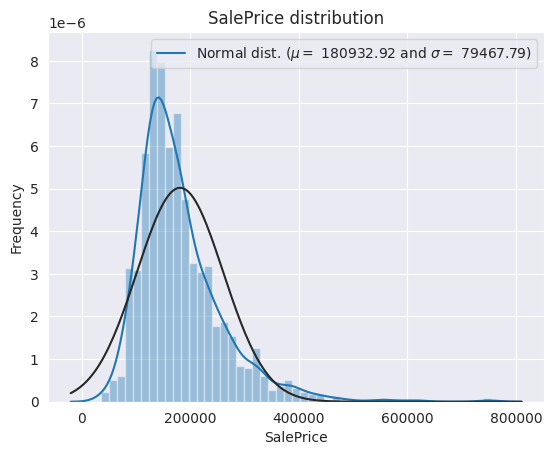

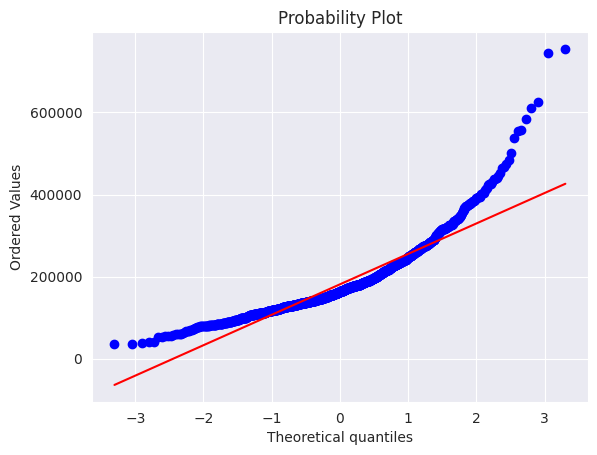

In [9]:
sns.distplot(train['SalePrice'], fit=norm);

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

target variable(SalePrice)가 right-skewed인 것을 확인했다. 선형모델은 정규분포를 선호하므로 transform을 하여 정규화시켜준다.

####**Log-trainsformation of the target variable**


 mu = 12.02 and sigma = 0.40



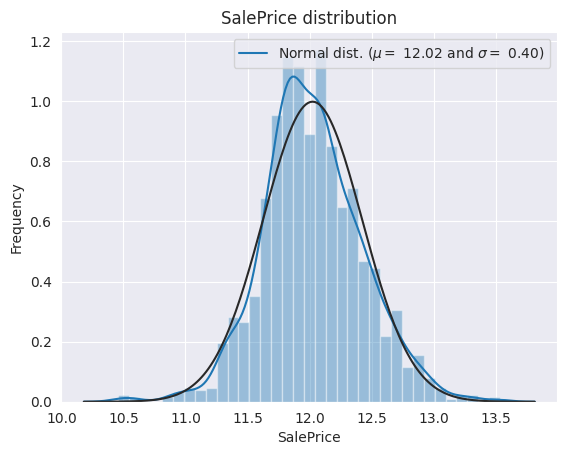

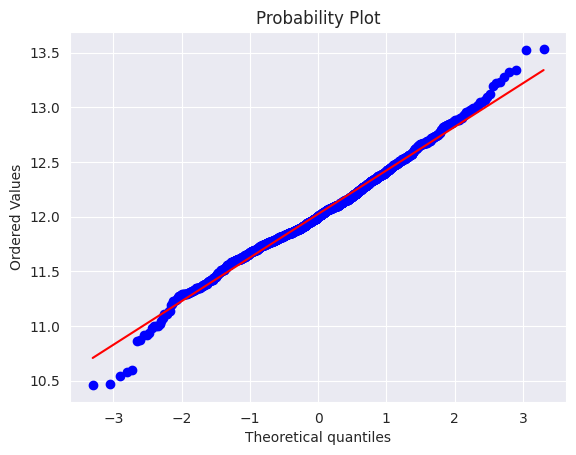

In [10]:
#We use the numpy fuction log1p which applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution
sns.distplot(train['SalePrice'], fit=norm);

#Get the fitted parameters used by the fuction
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

skew가 해결되고 정규화 되었다!

###**Features engineering**

In [11]:
#concatenate the train & test data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [12]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.000,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2913,160,RM,21.000,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2914,20,RL,160.000,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2915,85,RL,62.000,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


####**Missing Data**

In [13]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

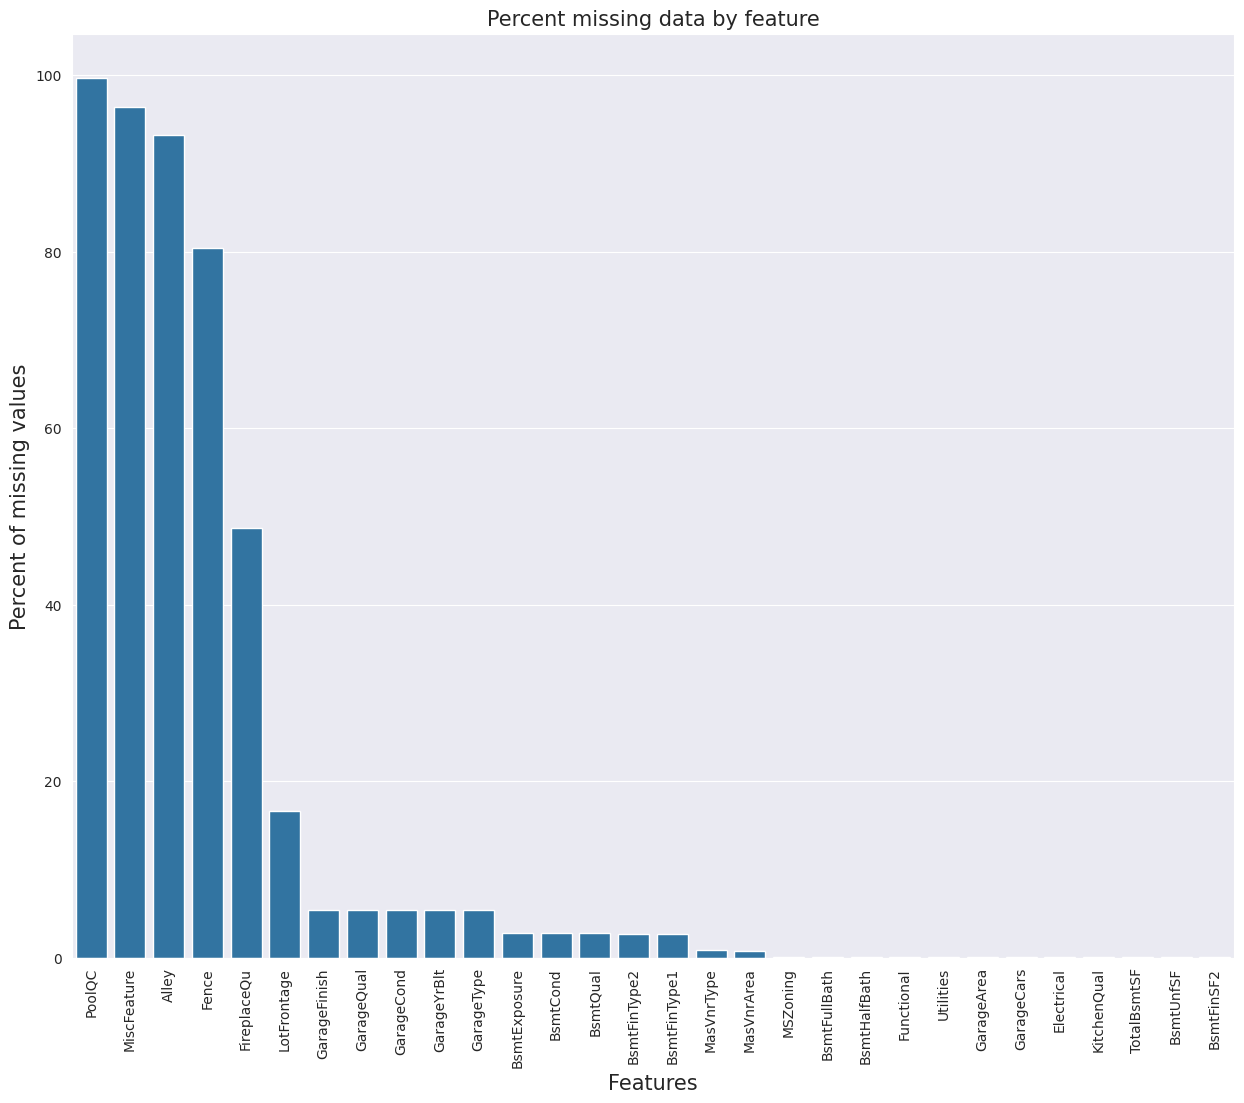

In [14]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

####**Data Correlation**

<Axes: >

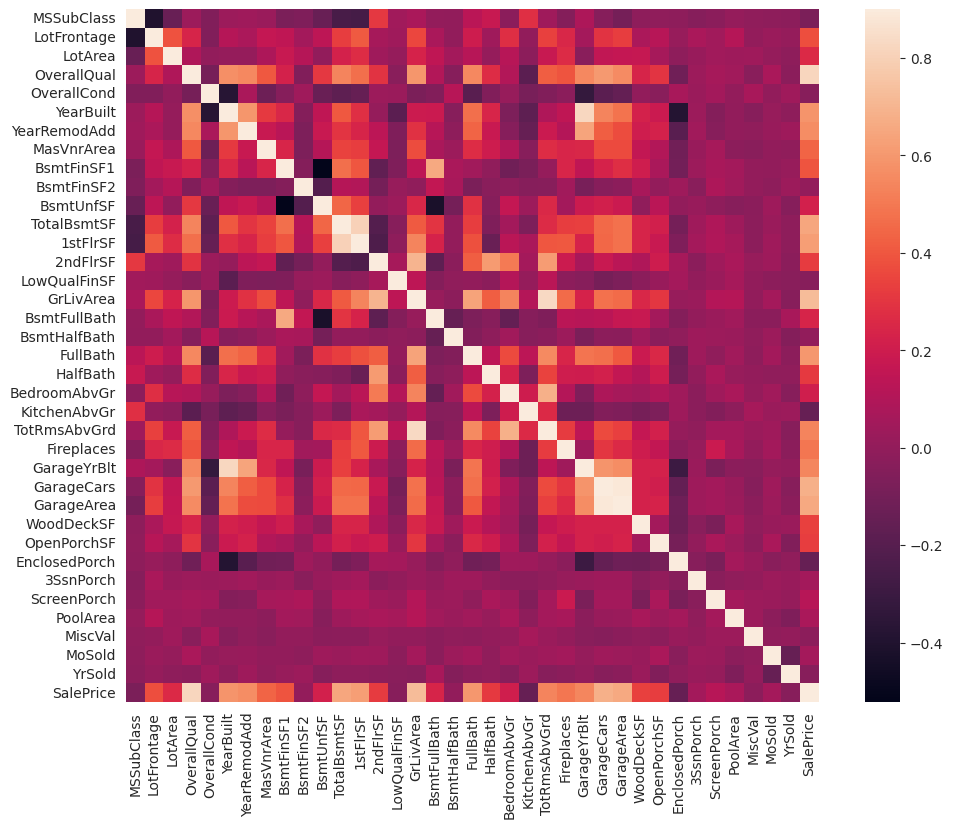

In [15]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

####**Imputing missing values**
We impute them by proceeding sequentially through features with missing values

- **PoolQC**: data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. (여기서 NA는 수영장이 없다는 것을 의미하고 99%의 다수의 집이 수영장을 가지고 있지 않으므로 이 칼럼은 의미가 있다)  

In [16]:
all_data["PoolQC"]=all_data["PoolQC"].fillna("None")

- **MiscFeature**: NA means "no misc feature"

In [17]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley**: NA means "no alley access"

In [18]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence**: NA means "no fence"

In [19]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu**: NA means "no fireplace"

In [20]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage(집에서 근처 지역 및 건물까지의 거리)**: Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood.**

In [21]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond**: Replacing missing data with None

In [22]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars**: Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [23]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**: missing values are likely zero for having no basement

In [24]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2**: For all these categorical basement-related features, NaN means that there is no basement

In [25]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [26]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)**: 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [27]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities**: For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.


In [28]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : NA means typical

In [29]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [30]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# mode(): 최빈값이 인덱스 0에 출력됨

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [31]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [32]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [33]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [34]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [35]:
#Check remaining missing valuew if any
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()
#No missing!

,Missing Ratio


####**More features engeneering**

#####**Transforming some numerical variables that are really categorical**

In [36]:
#MSSubClass = The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#####**Label Encoding some categorical variables that may contain information in their ordering set**

In [37]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
#process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c]=lbl.transform(list(all_data[c].values))

#shape
print('Shape all_data:{}'.format(all_data.shape))

Shape all_data:(2917, 78)


#####**Adding one more important feature**
주택 가격을 결정짓는데는 집의 전체 면적도 중요하므로 지하, 1층, 2층 면적의 합을 전체 면적 'TotalSF'을 만들어줌.

In [38]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#####**Skewed features**

In [39]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#####**Box Cox Transformation of (highly) skewed features**
We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+$x$  
setting λ=0 is equivalent to log1p used above for the target variable.  
- Box Cox Transformation: a statistical tool that transforms non-normal data into a normal distribution
 .

In [40]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam=0.15
for feat in skewed_features:
  #all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat], lam)

#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


#####**Getting dummy categorical features**

In [41]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


Getting the new train and test sets.

In [42]:
train = all_data[:ntrain]
test = all_data[ntrain:]

----------------------------
##**Modelling**
-----------------------------

#####**Import libraries**

In [43]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

##### **Define a cross validation strategy**
cross_val_score함수 사용.    
However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation -> KFold

In [44]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

###**Base models**

#####**LASSO Regression:**
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
- robust on outliers: 아웃라이어의 영향의 많이 받지 않는...

In [45]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

#####**Elastic Net Regression**
made robust to ouliers

In [46]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#####**Kernel Ridge Regression**
예측변수와 결과 사이의 선형 및 비선형 관계를 모델링할 수 있는 비모수 회귀분석 모델

In [47]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#####**Gradient Boosting Regression**
With huber loss that makes it robust to outliers

In [48]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

#####**XGBoost**

In [49]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640,
                             reg_lambda=0.8571, subsample=0.5213, silent=1, random_state=7, nthread=-1)

#####**LightGBM**

In [50]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720,
                              max_bin=55, baggin_fraction=0.8, bagging_req=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

####**Base models scores**
Let's see how these base models perform on the data by evaluating the cross-validation **rmsle error**

In [51]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f}({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1115(0.0074)



In [52]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [53]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f}({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153(0.0075)



In [54]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [55]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1162 (0.0078)



In [56]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] Unknown parameter: bagging_req
[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] Unknown parameter: bagging_req
[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGB

###**Stacking models:**
####**Simplest Stacking approach: Averageing base models**
We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse
- encapsulation(캡슐화): 클래스 안에 서로 연관있는 속성과 기능들을 하나의 캡슐(capsule)로 만들어 데이터를 외부로부터 보호하는 것을 말함.

##### **Averaged base models class**



In [57]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, models):
    self.models = models

  #we define clones of the original models to fit the data in
  def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models]

    #Train cloned base models
    for model in self.models_:
      model.fit(X,y)

    return self

  #Now we do the predictions for cloned models and average them
  def predict(self, X):
    predictions = np.column_stack([
        model.predict(X) for model in self.models_
    ])
    return np.mean(predictions, axis=1)

#####**Averaged base models score**
We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add more models in the mix.

In [58]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models socre: {:.4f}({:.4f})\n".format(score.mean(), score.std()))

Averaged base models socre: 0.1087(0.0077)



####**Less simple Stacking : Adding a Meta-model**
- averaged base models에 meta model을 추가함. base model의 out-of-folds 예측을 사용하여 메타 모델을 교육함.
- 훈련 절차   
 1. 전체 train을 두 개의 세트로 나눔(train 및 holdout)
 2. 첫 번째 train에서 여러 개의 base model 훈련
 3. 두 번째 holdout에서 같은 base model 테스트
 4. 더 높은 수준의 meta-model(학습자)을 훈련시키기 위해 out-of-folds 예측을 inputs으로 사용하여 target variable 출력함.
- step1~3은 반복적으로 수행됨.   
예> 5-fold stacking  
  1. train 데이터를 5 folds로 나눔
  2. 5번의 반복 수행. 각 반복에서 모든 base model을 4개 folds에서 훈련하고, 나머지 하나의 holdout folds를 예측함.
  3. 5번의 반복 후 전체 데이터를 사용하여 4단계에서 meta-model을 훈련하기 위한 new feature을 사용할 out-of-folds를 얻을 수 있음.
- 예측 부분에서는 test 데이터에 대한 모든 base model의 예측을 평균화하여 이를 meta-model로 최종 예측하는 feature로 사용함.

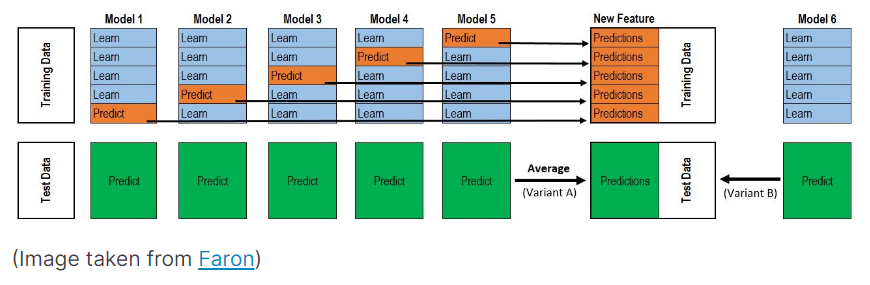

#####**Stacking averaged Models Class**



In [59]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

#####**Stacking Averaged models Score**
To make the two approaches comparable (by using the same number of models) , we just average Enet KRR and Gboost, then we add lasso as meta-model.

In [60]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


###**Ensembling StackedRegressor, XGBoost and LightGBM**
We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function

In [61]:
def rmsle(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

####**Final Training and Prediction**

#####**StackedRegressor**

In [62]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665937


#####**XGBoost**

In [63]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.08632034929442625


#####**LightGBM**

In [64]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] Unknown parameter: bagging_req
[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: bagging_req
[LightGBM] [Warning] Unknown parameter: baggin_fraction
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_

In [65]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))

RMSLE score on train data:
0.07664594175886821


#####**Ensemble prediction**

In [66]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

#####**Submission**

In [67]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub

,Id,SalePrice
0,1461,120360.148
1,1462,159274.809
2,1463,187515.359
3,1464,195918.110
4,1465,190532.425
...,...,...
1454,2915,84033.813
1455,2916,82466.992
1456,2917,168488.612
1457,2918,116518.210


In [68]:
#sub.to_csv('submission.csv', index=False)